In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

from pathlib import Path
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.feature_extraction import DictVectorizer

import keras
from keras import Sequential
from keras.layers import Dense, Conv1D, BatchNormalization, MaxPooling1D, Dropout, Flatten
from keras.utils import to_categorical

msdi_path = "../data/msdi/"

Using TensorFlow backend.


# MFCC

In [2]:
def load_mfcc(entry, msdi_path):
    x = np.load(Path(msdi_path) / entry['mfcc'])
    mfcc = x[entry['msd_track_id']]
    mfcc = np.mean(mfcc, axis=0)
    return(mfcc)

In [3]:
df_entry = pd.read_csv(msdi_path+"msdi_mapping.csv")
df_entry = df_entry.drop(["Unnamed: 0"], axis = 1)

In [4]:
X = df_entry.apply(lambda entry :
                            load_mfcc(entry, msdi_path), 
                            raw =True,
                            result_type='expand',
                            axis=1 )

In [7]:
label = df_entry['genre'].array
# print(label.shape)

le = LabelEncoder()
le.fit(label)
class_names = le.classes_
print("Classes : ", le.classes_, "\n")
y_classes = le.transform(label)

print(y_classes.shape)
y = to_categorical(y_classes)

Classes :  ['Blues' 'Country' 'Electronic' 'Folk' 'Jazz' 'Latin' 'Metal' 'New Age'
 'Pop' 'Punk' 'Rap' 'Reggae' 'RnB' 'Rock' 'World'] 

(30712,)


In [8]:
X = X.values

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [35]:
train_idx = df_entry.index[df_entry['set'] == "train"].tolist()
test_idx = df_entry.index[df_entry['set'] == "test"].tolist()
val_idx = df_entry.index[df_entry['set'] == "val"].tolist()

In [42]:
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]
X_val, y_val = X[val_idx], y[val_idx]

In [37]:
X_train.shape, y_train.shape

((21383, 12), (21383, 15))

In [45]:
nb_classes = len(le.classes_)
nb_features = len(X_train[0])
X_train, X_test, X_val = np.expand_dims(X_train, axis=-1), np.expand_dims(X_test, axis=-1), np.expand_dims(X_val, axis=-1)

In [46]:
X_train.shape, y_train.shape

((21383, 12, 1), (21383, 15))

In [84]:
model = Sequential()

model.add(Dense(64, input_shape=(nb_features,1)))
model.add(Dense(128))
model.add(Dense(256))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(nb_classes, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_138 (Dense)            (None, 12, 64)            128       
_________________________________________________________________
dense_139 (Dense)            (None, 12, 128)           8320      
_________________________________________________________________
dense_140 (Dense)            (None, 12, 256)           33024     
_________________________________________________________________
flatten_16 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_141 (Dense)            (None, 100)               307300    
_________________________________________________________________
dense_142 (Dense)            (None, 15)                1515      
Total params: 350,287
Trainable params: 350,287
Non-trainable params: 0
_______________________________________________

In [82]:
history = model.fit(X_train, y_train, batch_size=128, shuffle=True, epochs=10, validation_data=(X_val, y_val))

Train on 21383 samples, validate on 4680 samples
Epoch 1/50
21383/21383 [==============================] - 3s 161us/step - loss: 1.7822 - accuracy: 0.4048 - val_loss: 1.8729 - val_accuracy: 0.3835
Epoch 2/50
21383/21383 [==============================] - 3s 156us/step - loss: 1.7746 - accuracy: 0.4047 - val_loss: 1.8806 - val_accuracy: 0.3880
Epoch 3/50
21383/21383 [==============================] - 3s 157us/step - loss: 1.7766 - accuracy: 0.4092 - val_loss: 1.8555 - val_accuracy: 0.3874
Epoch 4/50
21383/21383 [==============================] - 3s 158us/step - loss: 1.7771 - accuracy: 0.4047 - val_loss: 1.8626 - val_accuracy: 0.3827
Epoch 5/50
21383/21383 [==============================] - 4s 165us/step - loss: 1.7729 - accuracy: 0.4103 - val_loss: 1.8420 - val_accuracy: 0.3921
Epoch 6/50
21383/21383 [==============================] - 3s 157us/step - loss: 1.7657 - accuracy: 0.4125 - val_loss: 1.8512 - val_accuracy: 0.3846
Epoch 7/50
21383/21383 [==============================] - 3s 15

In [57]:
model.evaluate(X_test, y_test)

4649/4649 [==============================] - 1s 214us/step


[1.796231284375395, 0.3904065489768982]

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


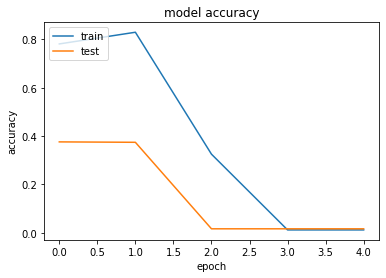

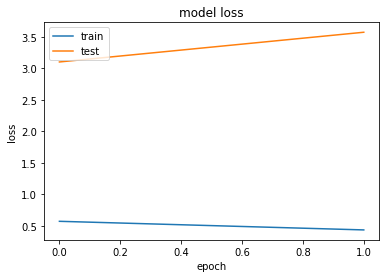

In [158]:
import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [89]:
model._layers.pop()
model2 = keras.Model(model.input, model.layers[-1].output)
model2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_138_input (InputLayer) (None, 12, 1)             0         
_________________________________________________________________
dense_138 (Dense)            (None, 12, 64)            128       
_________________________________________________________________
dense_139 (Dense)            (None, 12, 128)           8320      
_________________________________________________________________
dense_140 (Dense)            (None, 12, 256)           33024     
_________________________________________________________________
flatten_16 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_141 (Dense)            (None, 100)               307300    
Total params: 348,772
Trainable params: 348,772
Non-trainable params: 0
_____________________________________________________

In [91]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [94]:
Y_latent = model2.predict(np.expand_dims(X, axis=-1))
print(Y_latent.shape)


(30712, 100)


In [95]:
df_proba = pd.DataFrame(data = Y_latent)
df_final = df_entry.join(df_proba)

In [96]:
df_final.drop(['album_index',
       'msd_artist_id', 'image_url', 'img', 'mfcc', 'deep_features'], axis=1, inplace=True)

In [98]:
export_csv = df_final.to_csv (r'../data/mfcc_latent.csv', index = None, header=True)

# Deep Audio

In [99]:
def load_deep_audio_features(entry, msdi_path, X_train,X_val,X_test ):
    data_set = entry['set']
    idx = entry['deep_features']
    if data_set == 'train':
        return X_train[idx, :].tolist()
    if data_set == 'val':
        return X_val[idx,:].tolist()
    else:
        return X_test[idx,:].tolist()

In [100]:
df_entry = pd.read_csv(msdi_path+"msdi_mapping.csv")
df_entry = df_entry.drop(["Unnamed: 0"], axis = 1)

In [101]:
X_train = np.load(msdi_path + "deep_features/X_train_audio_MSD-I.npy")
X_val = np.load(msdi_path + "deep_features/X_val_audio_MSD-I.npy")
X_test = np.load(msdi_path + "deep_features/X_test_audio_MSD-I.npy")

In [102]:
train_idx = df_entry.index[df_entry['set'] == "train"].tolist()
test_idx = df_entry.index[df_entry['set'] == "test"].tolist()
val_idx = df_entry.index[df_entry['set'] == "val"].tolist()

In [103]:
X = df_entry.apply(lambda entry :
                            load_deep_audio_features(entry, msdi_path, X_train, X_val, X_test), 
                            raw =True,
                            result_type='expand',
                            axis=1 )

In [104]:
label = df_entry['genre'].array
# print(label.shape)

le = LabelEncoder()
le.fit(label)
class_names = le.classes_
print("Classes : ", le.classes_, "\n")
y_classes = le.transform(label)

print( y_classes.shape)
y = to_categorical(y_classes)

Classes :  ['Blues' 'Country' 'Electronic' 'Folk' 'Jazz' 'Latin' 'Metal' 'New Age'
 'Pop' 'Punk' 'Rap' 'Reggae' 'RnB' 'Rock' 'World'] 

(30712,)


In [105]:
X =  X.values
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]
X_val, y_val = X[val_idx], y[val_idx]

In [106]:
nb_classes = len(le.classes_)
nb_features = len(X_train[0])
X_train, X_test, X_val = np.expand_dims(X_train, axis=-1), np.expand_dims(X_test, axis=-1), np.expand_dims(X_val, axis=-1)

In [107]:
X_train.shape, y_train.shape

((21383, 2048, 1), (21383, 15))

In [124]:
model = Sequential()


model.add(Dense(32,input_shape=(nb_features,1)))
model.add(Dense(16))
model.add(Flatten())
model.add(Dense(16))

model.add(Dense(100))
model.add(Dense(nb_classes, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_190 (Dense)            (None, 2048, 32)          64        
_________________________________________________________________
dense_191 (Dense)            (None, 2048, 16)          528       
_________________________________________________________________
flatten_27 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_192 (Dense)            (None, 16)                524304    
_________________________________________________________________
dense_193 (Dense)            (None, 100)               1700      
_________________________________________________________________
dense_194 (Dense)            (None, 15)                1515      
Total params: 528,111
Trainable params: 528,111
Non-trainable params: 0
_______________________________________________

In [125]:
history = model.fit(X_train, y_train, batch_size=128, shuffle=True, epochs=3, validation_data=(X_val, y_val))

Train on 21383 samples, validate on 4680 samples
Epoch 1/3
21383/21383 [==============================] - 18s 836us/step - loss: 1.6386 - accuracy: 0.4746 - val_loss: 1.6838 - val_accuracy: 0.4566
Epoch 2/3
21383/21383 [==============================] - 18s 822us/step - loss: 1.4436 - accuracy: 0.5327 - val_loss: 1.6765 - val_accuracy: 0.4650
Epoch 3/3
21383/21383 [==============================] - 18s 827us/step - loss: 1.4170 - accuracy: 0.5383 - val_loss: 1.6431 - val_accuracy: 0.4705


In [126]:
model._layers.pop()
model2 = keras.Model(model.input, model.layers[-1].output)
model2.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_190_input (InputLayer) (None, 2048, 1)           0         
_________________________________________________________________
dense_190 (Dense)            (None, 2048, 32)          64        
_________________________________________________________________
dense_191 (Dense)            (None, 2048, 16)          528       
_________________________________________________________________
flatten_27 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_192 (Dense)            (None, 16)                524304    
_________________________________________________________________
dense_193 (Dense)            (None, 100)               1700      
Total params: 526,596
Trainable params: 526,596
Non-trainable params: 0
_____________________________________________________

In [127]:
Y_latent = model2.predict(np.expand_dims(X, axis=-1))
print(Y_latent.shape)

(30712, 100)


In [128]:
df_proba = pd.DataFrame(data = Y_latent)
df_final = df_entry.join(df_proba)

In [129]:
df_final.drop(['album_index',
       'msd_artist_id', 'image_url', 'img', 'mfcc', 'deep_features'], axis=1, inplace=True)

In [130]:
export_csv = df_final.to_csv (r'../data/deep_audio_latent.csv', index = None, header=True)

# Bag of Word

In [2]:
df_bow = pd.read_csv('../data/msx_lyrics_genre.txt',  sep="|", names=['A'])

In [3]:
cols = ["msd_track_id", "genre", "bow"]
df_bow[cols] = df_bow.A.str.split(' ', n=2, expand=True)
df_bow.drop('A', axis=1, inplace=True)
df_bow['bow'] = df_bow['bow'].apply(lambda bow : dict([el.split(':') for el in bow.split(' ') if el!=""]))
df_bow['bow'] = df_bow['bow'].apply(lambda bow : dict([a, int(x)] for a, x in bow.items()))
df_bow.head()

,msd_track_id,genre,bow
0,TRAAAHZ128E0799171,Rap,"{'1': 39, '2': 30, '3': 10, '4': 10, '5': 28, ..."
1,TRAACER128F4290F96,Metal,"{'1': 4, '2': 11, '3': 19, '4': 4, '5': 4, '6'..."
2,TRAADYB128F92D7E73,Jazz,"{'1': 23, '2': 18, '3': 31, '5': 4, '7': 3, '8..."
3,TRAAEJV128F423CF04,Pop,"{'1': 11, '3': 19, '6': 3, '7': 1, '10': 1, '1..."
4,TRAAERZ128F1496921,Reggae,"{'1': 13, '2': 12, '3': 9, '4': 3, '5': 13, '6..."


In [4]:
df_mapping = pd.read_csv("../data/msdi/msdi_mapping.csv")
df_mapping.drop(['Unnamed: 0', 'genre', 'album_index',
       'msd_artist_id', 'image_url', 'img', 'mfcc', 'deep_features'], axis=1, inplace=True)
df_mapping.head()

,msd_track_id,set
0,TRABKJU128F422A7FE,train
1,TRBLDQQ128F92E58B4,train
2,TRDMMDE128F14A9052,train
3,TRJOPZB128F4250E02,train
4,TRJKBVL128F935567B,train


In [5]:
df_bow = pd.merge(df_bow, df_mapping, on="msd_track_id")
df_bow.head()

,msd_track_id,genre,bow,set
0,TRAAAHZ128E0799171,Rap,"{'1': 39, '2': 30, '3': 10, '4': 10, '5': 28, ...",train
1,TRAACER128F4290F96,Metal,"{'1': 4, '2': 11, '3': 19, '4': 4, '5': 4, '6'...",train
2,TRAADYB128F92D7E73,Jazz,"{'1': 23, '2': 18, '3': 31, '5': 4, '7': 3, '8...",train
3,TRAAEJV128F423CF04,Pop,"{'1': 11, '3': 19, '6': 3, '7': 1, '10': 1, '1...",val
4,TRAAERZ128F1496921,Reggae,"{'1': 13, '2': 12, '3': 9, '4': 3, '5': 13, '6...",val


In [6]:
v = DictVectorizer(sparse=False)
X = v.fit_transform(df_bow["bow"])

print(X.shape)

(14750, 5000)


In [7]:
train_idx = df_bow.index[df_bow['set'] == "train"].tolist()
test_idx = df_bow.index[df_bow['set'] == "test"].tolist()
val_idx = df_bow.index[df_bow['set'] == "val"].tolist()


In [8]:
label = df_bow['genre'].array
# print(label.shape)

le = LabelEncoder()
le.fit(label)
class_names = le.classes_
print("Classes : ", le.classes_, "\n")
y_classes = le.transform(label)

print( y_classes.shape)
y = to_categorical(y_classes)

Classes :  ['Blues' 'Country' 'Electronic' 'Folk' 'Jazz' 'Latin' 'Metal' 'New_Age'
 'Pop' 'Punk' 'Rap' 'Reggae' 'RnB' 'Rock' 'World'] 

(14750,)


In [9]:
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]
X_val, y_val = X[val_idx], y[val_idx]

In [10]:
nb_classes = len(le.classes_)
nb_features = len(X_train[0])
#X_train, X_test, X_val = np.expand_dims(X_train, axis=-1), np.expand_dims(X_test, axis=-1), np.expand_dims(X_val, axis=-1)

In [11]:
X_train.shape, y_train.shape

((10340, 5000), (10340, 15))

In [12]:
model = Sequential()


model.add(Dense(32,input_dim=(nb_features)))
model.add(BatchNormalization())
model.add(Dense(100))
model.add(Dense(nb_classes, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                160032    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               3300      
_________________________________________________________________
dense_3 (Dense)              (None, 15)                1515      
Total params: 164,975
Trainable params: 164,911
Non-trainable params: 64
_________________________________________________________________


In [13]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, validation_data=(X_val, y_val))

Train on 10340 samples, validate on 2298 samples
Epoch 1/5
10340/10340 [==============================] - 2s 191us/step - loss: 2.3880 - accuracy: 0.3212 - val_loss: 2.2544 - val_accuracy: 0.3333
Epoch 2/5
10340/10340 [==============================] - 1s 96us/step - loss: 1.9095 - accuracy: 0.4273 - val_loss: 1.9459 - val_accuracy: 0.3486
Epoch 3/5
10340/10340 [==============================] - 1s 94us/step - loss: 1.5277 - accuracy: 0.4362 - val_loss: 2.0278 - val_accuracy: 0.3468
Epoch 4/5
10340/10340 [==============================] - 1s 103us/step - loss: 1.2412 - accuracy: 0.5398 - val_loss: 2.1614 - val_accuracy: 0.3847
Epoch 5/5
10340/10340 [==============================] - 1s 98us/step - loss: 1.0101 - accuracy: 0.6256 - val_loss: 2.3677 - val_accuracy: 0.3786


In [14]:
model._layers.pop()
model2 = keras.Model(model.input, model.layers[-1].output)
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1_input (InputLayer)   (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                160032    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               3300      
Total params: 163,460
Trainable params: 163,396
Non-trainable params: 64
_________________________________________________________________


In [15]:
Y_latent = model2.predict(X)
print(Y_latent.shape)

(14750, 100)


In [16]:
df_proba = pd.DataFrame(data = Y_latent)
df_final = df_bow.join(df_proba)

In [19]:
df_final = df_final.drop("bow", axis = 1)

In [21]:
export_csv = df_final.to_csv (r'../data/bow_latent.csv', index = None, header=True)

In [20]:
df_final.head()

,msd_track_id,genre,set,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
0,TRAAAHZ128E0799171,Rap,train,-2.067585,2.651733,3.320567,0.084567,0.150504,-2.050568,0.975501,...,-3.452422,1.678107,1.147188,3.000128,-2.506208,-1.890682,0.423336,-1.765437,0.097919,-1.165544
1,TRAACER128F4290F96,Metal,train,-1.510375,-0.630707,0.881289,-0.207258,0.062911,0.168616,1.256322,...,-1.468447,0.982858,-1.308412,1.714285,-1.445258,-0.254049,1.792565,-1.714414,1.096439,-1.839709
2,TRAADYB128F92D7E73,Jazz,train,-0.870939,-0.871925,-0.486669,0.006040,0.220190,0.576865,0.367615,...,-0.622740,-0.308450,-1.609737,1.391620,-0.828036,0.520239,1.533222,0.074795,1.362022,-0.893388
3,TRAAEJV128F423CF04,Pop,val,-0.377768,-0.452566,0.560932,-0.132178,-0.392075,0.220614,0.823778,...,-1.028710,-0.340106,-0.554905,0.759968,-1.194390,0.018122,0.639118,-0.751301,0.622499,-0.852462
4,TRAAERZ128F1496921,Reggae,val,-0.639578,-1.247270,-0.301092,-1.002917,0.780277,1.926255,-0.551522,...,-0.048481,0.647069,-1.882395,1.287668,-0.174276,0.135435,1.690100,-0.262641,1.413104,-0.403483
